In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

class MultipleDomainDataset:
    N_STEPS = 5001           # Default, subclasses may override
    CHECKPOINT_FREQ = 100    # Default, subclasses may override
    N_WORKERS = 8            # Default, subclasses may override
    ENVIRONMENTS = None      # Subclasses should override
    INPUT_SHAPE = None       # Subclasses should override

    def __getitem__(self, index):
        return self.datasets[index]

    def __len__(self):
        return len(self.datasets)

class MultipleEnvironmentImageFolder(MultipleDomainDataset):
    def __init__(self, root, test_envs, augment):
        super().__init__()
        environments = [f.name for f in os.scandir(root) if f.is_dir()]
        environments = sorted(environments)

        transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        augment_transform = transforms.Compose([
            # transforms.Resize((224,224)),
            transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
            transforms.RandomGrayscale(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.datasets = []
        for i, environment in enumerate(environments):

            if augment and (i not in test_envs):
                env_transform = augment_transform
            else:
                env_transform = transform

            path = os.path.join(root, environment)
            env_dataset = ImageFolder(path,
                transform=env_transform)

            self.datasets.append(env_dataset)

        self.input_shape = (3, 224, 224,)
        self.num_classes = len(self.datasets[-1].classes)

class OfficeHome(MultipleEnvironmentImageFolder):
    CHECKPOINT_FREQ = 300
    ENVIRONMENTS = ["A", "C", "P", "R"]
    def __init__(self, root, test_envs):
        self.dir = os.path.join(root, "office_home/")
        super().__init__(self.dir, test_envs, True)


class _SplitDataset(torch.utils.data.Dataset):
    """Used by split_dataset"""
    def __init__(self, underlying_dataset, keys):
        super(_SplitDataset, self).__init__()
        self.underlying_dataset = underlying_dataset
        self.keys = keys
    def __getitem__(self, key):
        return self.underlying_dataset[self.keys[key]]
    def __len__(self):
        return len(self.keys)

def split_dataset(dataset, n, seed=0):
    """
    Return a pair of datasets corresponding to a random split of the given
    dataset, with n datapoints in the first dataset and the rest in the last,
    using the given random seed
    """
    assert(n <= len(dataset))
    keys = list(range(len(dataset)))
    np.random.RandomState(seed).shuffle(keys)
    keys_1 = keys[:n]
    keys_2 = keys[n:]
    return _SplitDataset(dataset, keys_1), _SplitDataset(dataset, keys_2)

In [31]:
dataset_all = OfficeHome("/home/katie/Desktop/DomainBed/domainbed/data/", [0, 1, 3])

test_data, train_data  = split_dataset(dataset_all[2], int(len(dataset_all[2])*0.2))
dataset = train_data



In [32]:
len(test_data)

887

In [33]:
num_classes = 65

In [34]:
class_probs = []
targets = np.array(dataset.underlying_dataset.targets)[np.array(dataset.keys)]
for class_idx in range(num_classes):
    class_probs.append(np.sum(np.array(targets) == class_idx)/len(dataset))

In [35]:
class_probs = np.array(class_probs)
f_star = class_probs*1+(1-class_probs)*-4
f_star = np.append(f_star, 0)

In [36]:
test_targets = np.array(test_data.underlying_dataset.targets)[np.array(test_data.keys)]

labels_all = [test_targets, dataset_all[0].targets, dataset_all[1].targets, dataset_all[3].targets]

In [37]:
len(np.array(train_data.keys))

3552

In [38]:
len(test_targets)

887

In [39]:
len(dataset_all[0].targets)

2427

In [40]:
labels = np.array(labels)


dict_keys([0, 1, 2, 3])
(887, 66)
(4357, 66)
(4365, 66)
(2427, 66)
dict_keys([0, 1, 2, 3])
(887, 66)
(4357, 66)
(4365, 66)
(2427, 66)
dict_keys([0, 1, 2, 3])
(887, 66)
(4357, 66)
(4365, 66)
(2427, 66)
dict_keys([0, 1, 2, 3])
(887, 66)
(4357, 66)
(4365, 66)
(2427, 66)
dict_keys([0, 1, 2, 3])
(887, 66)
(4357, 66)
(4365, 66)
(2427, 66)


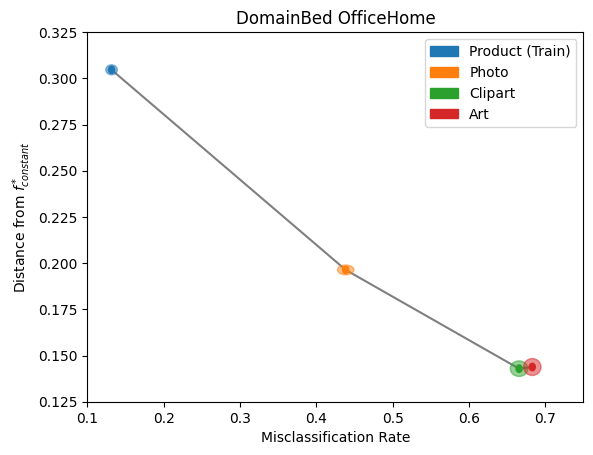

In [41]:
run_names = ["officehome_seed0", "officehome_seed1", "officehome_seed2", "officehome_seed3", "officehome_seed4"]

accuracies_all = []
dist_from_f_starts_all = []
for run_name in run_names:
    with open("data/"+run_name+'/outputs.pkl', 'rb') as f:
        data = pickle.load(f)
    print(data.keys())

    

    accuracies = []
    dist_from_f_starts = []
    for corruption_level in ([0, 3, 2, 1]):
        dist_from_f_start = ((data[corruption_level] - np.expand_dims(f_star, axis=0))**2).mean()
        print(data[corruption_level].shape)
        accuracy = (np.array(data[corruption_level][:, :-1].argmax(axis=-1))==np.array(labels_all[corruption_level])).mean()
        accuracies.append(accuracy)
        dist_from_f_starts.append(dist_from_f_start)
    accuracies_all.append(accuracies)
    dist_from_f_starts_all.append(dist_from_f_starts)
accuracies_all = np.array(accuracies_all)
dist_from_f_starts_all = np.array(dist_from_f_starts_all)
# plt.plot(1-np.array(accuracies_all.mean(axis=0)), dist_from_f_starts_all.mean(axis=0), "o-")
# #plot error bars
# plt.fill_between(1-np.array(accuracies_all.mean(axis=0)), dist_from_f_starts_all.mean(axis=0)-dist_from_f_starts_all.std(axis=0), dist_from_f_starts_all.mean(axis=0)+dist_from_f_starts_all.std(axis=0), alpha=0.2)
# plt.legend()


labels = ["Product (Train)", "Photo", "Clipart", "Art"]
from matplotlib.patches import Ellipse
plt.figure()
ax = plt.gca()
colors = ["C0", "C1", "C2", "C3"]
plt.plot(1-np.array(accuracies_all.mean(axis=0)), dist_from_f_starts_all.mean(axis=0), c = "black", alpha=0.5, zorder=-1)
for i in range(4):
    ellipse = Ellipse(xy=(1-accuracies_all.mean(axis=0)[i], dist_from_f_starts_all.mean(axis=0)[i]), width=accuracies_all.std(axis=0)[i], height=dist_from_f_starts_all.std(axis=0)[i], color=colors[i], alpha=0.5)
                            # edgecolor='r', fc='None', lw=2)
    ax.add_patch(ellipse, )
    r = 0.004
    ellipse = Ellipse(xy=(1-accuracies_all.mean(axis=0)[i], dist_from_f_starts_all.mean(axis=0)[i]), width=r*2, height=r, color=colors[i])
                            # edgecolor='r', fc='None', lw=2)
    ax.add_patch(ellipse, )
    ellipse.set(label = labels[i])
plt.xlabel("Misclassification Rate")
plt.ylabel("Distance from $f^*_{constant}$")
plt.ylim(0.125, 0.325)
plt.xlim(0.1, 0.75)
plt.title("DomainBed OfficeHome")

plt.legend()

In [60]:
with open("data/"+run_names[0]+'/outputs.pkl', 'rb') as f:
    data = pickle.load(f)
print(data.keys())

dict_keys([0, 1, 2, 3])


In [61]:
data[0]

array([[-3.97966695, -4.06211472, -4.04993248, ..., -4.00901079,
        -3.96747565,  0.04879395],
       [-4.0476203 , -4.00892448, -4.06067562, ..., -3.93343234,
        -4.02931643,  0.02581985],
       [-3.98218155, -3.98605514, -4.03574657, ..., -3.96869206,
        -3.97410417,  0.01626987],
       ...,
       [-4.05354118, -4.08010101, -4.0274682 , ..., -4.01679754,
        -4.00088453,  0.03117603],
       [-4.05271387, -4.00736141, -4.0273366 , ..., -4.00647593,
        -3.95844483,  0.00797695],
       [-3.99164224, -3.99818993, -4.02550602, ..., -4.03868341,
        -3.95541263,  0.021038  ]])